# Exercise 14.1

This exercise is also inspired by an example in Jaynes, Probability Theory.

Suppose you buy a mosquito trap that is supposed to reduce the population of mosquitoes near your house. Each week, you empty the trap and count the number of mosquitoes captured. After the first week, you count 30 mosquitoes. After the second week, you count 20 mosquitoes. Estimate the percentage change in the number of mosquitoes in your yard.

To answer this question, you have to make some modeling decisions. Here are some suggestions:
- Suppose that each week a large number of mosquitoes, N, is bred in a wetland near your home.
- During the week, some fraction of them, f1, wander into your yard, and of those some fraction, f2, are caught in the trap.
- Your solution should take into account your prior belief about how much N is likely to change from one week to the next. You can do that by adding a level to the hierarchy to model the percent change in N.

### Theory

The solution to this problem is almost given in the chapter itself, disguised as the Geiger counter problem. I'll reuse some of the authors words.

To get started on a problem like this, think about the chain of causation that starts with the parameters of the system and ends with the observed data:

<table>
    <tr>
        <th></th><th>Geiger</th><th>Mosquitoes</th>
    </tr>
    <tr>
        <td>1</td>
        <td>The source emits particles at an average rate, r.</td>
        <td>The wetland near your home emits mosquitoes at an average rate $N$ every week</td>
    </tr>
    <tr>
        <td>2</td>
        <td>During any given second, the source emits $n$ particles toward the counter.</td>
        <td>During the week, $n$ ($Nf_1$) are emited towards your home</td>
    </tr>
    <tr>
        <td>3</td>
        <td>Out of those $n$ particles, some number, $k$, get counted.</td>
        <td>Out of those $n$ mosquitoes, some number, $k$ ($nf_2$), get counted (trapped)</td>
    </tr>
</table>


#### Let's start simple

- We know $k$ from the problem. Let's work with 30
- We don't know $f_2$, the fraction that the zapper can catch.
- For now we will assume we know how many mosquitoes are in our yard, say 50
- Catching a mosquito is independent of the others. Then $k \sim Binomial(50 ,f_2)$

I have absolutely no idea how to model a bug zapper, so I'll say that every value for the binomial is possible.

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'code'))

In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [111]:
from thinkbayes2 import MakeUniformPmf, Suite, EvalBinomialPmf, MakePmfFromItems, MakePoissonPmf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [56]:
class Zapper(Suite):
    def __init__(self, n, step=100):
        f_2 = MakeUniformPmf(0, 1, step)
        self.n = n
        Suite.__init__(self, f_2, label=n)
        
    def Likelihood(self, data, hypo):
        k = data
        p = hypo
        return EvalBinomialPmf(k, self.n, p)
    
    def SuiteLikelihood(self, data):
        total = 0
        for hypo, prob in self.Items():
            like = self.Likelihood(data, hypo)
            total += prob * like
        return total

In [57]:
zapper = Zapper(50)
zapper.Update(30)

0.019411764705882236

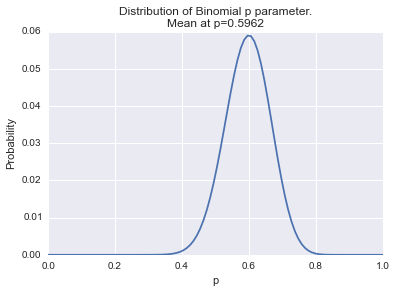

In [58]:
f, prob = zip(*sorted(zapper.Items()))
plt.plot(f, prob)
plt.title('Distribution of Binomial p parameter.\nMean at p={:.4f}'.format(zapper.Mean()))
plt.xlabel('p')
_ = plt.ylabel('Probability')

That looks good for modeling the zapper. We created a suite that models the efficiency of a zapper based on the data that we have. Now we will relaxe the assumption about $n$, which comes from $N*f_1$. A fraction $f_1$ of the $N$ mosquitoes born in the wetland comes to your yard. Again, no idea what that fraction could be. No prior at all, so let's say again that it's uniform.

We will add a hierarchy now by setting N at 500 and letting $f_1$ free.

In [103]:
class Yard(Suite):
    def __init__(self, N, step=100):
        Zappers = [Zapper(N*f1) for f1 in np.linspace(0,1,step)]
        self.N = N
        Suite.__init__(self, Zappers, label=N)

    def Likelihood(self, data, hypo):
        zapper = hypo
        like = zapper.SuiteLikelihood(data)
        return like
    
    def Update(self, data):
        Suite.Update(self, data)
        zapper_to_remove = []
        for zapper in self.Values():
            if zapper.label < data:
                zapper_to_remove.append(zapper)
            else:
                zapper.Update(data)
        # Removing the zapper with the assumption where n < data
        for zapper in zapper_to_remove:
            self.Remove(zapper)
            
    def DistOfN(self):
        items = [(zapper.n, prob) for zapper, prob in self.Items()]
        return MakePmfFromItems(items)

In [104]:
yard = Yard(500)
yard.Update(30)

In [105]:
dist_of_n = yard.DistOfN()
n, prob = zip(*sorted(dist_of_n.Items()))

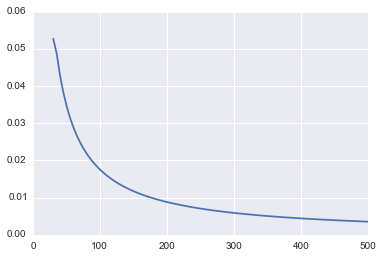

In [106]:
plt.plot(np.array(n), prob)

According to this, the most probable value for $n$ is around 30, which is how many we catched. That means I'm catching every single mosquitoes. Something must be wrong.

Using the parallel with the detector where the source was emitting at an average rate $r$, $n$ particules were hitting the detector and only a fraction $f$ were detected. $n$ was following a Poisson distribution with parameter $r$.

So if we say that the wetland is emitting mosquitoes at an average rate of $N$, $n$ ($=Nf_1$) is just the same distribution scaled by $f_1$. So let's work with that instead, $n \sim Poisson(Nf_1)$. Let's fix $f_1$ for now at 1%.

In [112]:
class Zapper(Suite):
    def __init__(self, N, f_1=0.01, f_2=0.1, high=500, step=1):
        pmf = MakePoissonPmf(N*f_1, high, step)
        self.f_1 = f_1
        self.f_2 = f_2
        Suite.__init__(self, pmf, label=N)
        
    def Likelihood(self, data, hypo):
        k = data
        n = hypo
        p = self.f_2
        return EvalBinomialPmf(k, n, p)
    
    def SuiteLikelihood(self, data):
        total = 0
        for hypo, prob in self.Items():
            like = self.Likelihood(data, hypo)
            total += prob * like
        return total

In [114]:
zapper = Zapper(50)

In [115]:
zapper.Update(30)

3.3398374566187909e-72